# ECG Data Analysis
In this notebook, I will carry out a **fast analysis** of some ECG data. 

There is a file (<font color=DarkGoldenRod>ecg_features.csv</font>) which contains features extracted from ECG signals of human subjects and the labels (i.e., four classes). I will train a classifier that predicts the label based on the features, considering that we do not have any previous knowledge about the data (i.e., the nature of the features), except that there are feature dependencies.

First, I import the necessary libraries for the whole process:

In [1]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

Let's look at the ecg file:

In [2]:
df = pd.read_csv("ecg_features.csv", sep=',')
df.head()

,Unnamed: 0,label,variance_ar_p,ar1_pq,ar2_pq,ar3_pq,ar4_pq,variance_ar_pq,ar1_qrs,ar2_qrs,...,categ_feat10,categ_feat11,categ_feat12,categ_feat13,categ_feat14,categ_feat15,categ_feat16,categ_feat17,categ_feat18,categ_feat19
0,0,0,63.587938,-1.417539,0.806484,-0.219239,0.030321,61.988036,-1.264411,1.122517,...,T1,I2,D2,F4,I3,U1,N4,S2,J5,N2
1,1,0,14.533744,-1.352489,0.636449,-0.063630,0.000952,8.414471,-1.167240,0.982375,...,T1,I2,D2,F6,I2,U1,N4,S2,J6,N0
2,2,0,2054.613117,-1.409604,0.712848,-0.296348,0.118116,682.018315,-1.575944,1.012717,...,T1,I2,D0,F4,I3,U1,N4,S2,J5,N2
3,3,0,68.916787,-1.227225,0.359249,0.101290,-0.037858,52.275008,-0.880402,0.677413,...,T1,I1,D0,F4,I3,U1,N4,S1,J3,N2
4,4,0,92.823028,-1.132082,0.530452,-0.159948,0.052240,89.460268,-1.332283,1.152151,...,T2,I2,D4,F5,I3,U1,N4,S2,J4,N2


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,label,variance_ar_p,ar1_pq,ar2_pq,ar3_pq,ar4_pq,variance_ar_pq,ar1_qrs,ar2_qrs,ar3_qrs,...,categ_feat10,categ_feat11,categ_feat12,categ_feat13,categ_feat14,categ_feat15,categ_feat16,categ_feat17,categ_feat18,categ_feat19
0,0,63.587938,-1.417539,0.806484,-0.219239,0.030321,61.988036,-1.264411,1.122517,-0.634373,...,T1,I2,D2,F4,I3,U1,N4,S2,J5,N2
1,0,14.533744,-1.352489,0.636449,-0.063630,0.000952,8.414471,-1.167240,0.982375,-0.567293,...,T1,I2,D2,F6,I2,U1,N4,S2,J6,N0
2,0,2054.613117,-1.409604,0.712848,-0.296348,0.118116,682.018315,-1.575944,1.012717,-0.558049,...,T1,I2,D0,F4,I3,U1,N4,S2,J5,N2
3,0,68.916787,-1.227225,0.359249,0.101290,-0.037858,52.275008,-0.880402,0.677413,-0.358651,...,T1,I1,D0,F4,I3,U1,N4,S1,J3,N2
4,0,92.823028,-1.132082,0.530452,-0.159948,0.052240,89.460268,-1.332283,1.152151,-0.680227,...,T2,I2,D4,F5,I3,U1,N4,S2,J4,N2


In [4]:
print('Number of ECG signals = ', len(df))

Number of ECG signals =  8528


Therefore, in the above table, there are 8528 signals. The first column indicates the labels, and the columns 2-70 are the features. We see that some features are numerical (the first 50 columns) while some are categorial (the last 20 columns).

One approach to solve such a proplem can be constructing separate models for numerical and categorial features, then combining their results to provide the final prediction. For this problem, I intend to do the following steps:
    1. Consider a baseline for prediction.
    2. Construct a logistic regression classifier for the the first 50 numerical features (Classifier-I).
    3. Construct a logistic regression classifier for the last 20 categorial features (Classifier-II).
    4. Implement a voting classifier over the two classifiers.
    

## 1. Baseline

It useful to have a base line for predictions:

In [5]:
print(df.label.value_counts(normalize= True))

0    0.592167
2    0.287992
1    0.086538
3    0.033302
Name: label, dtype: float64


Alright. Above predictions show that we have an imbalances dataset, i.e., about 60% of samples have Label-0, 30% Label-2, while Label-1 or Label-3 are less than 1%. 

## 2. Classifier-I

Construct a logistic regression classifier for the the first 50 numerical features.

First, I extract features and target values:

In [6]:
XN = df.iloc[:,0:51].copy() 
y = XN.pop('label')

Train and test split with 80:20 ratio (+ stratifying as our
data is imbalanced):

In [7]:
XN_train, XN_test, y_train, y_test = train_test_split(XN, y, test_size=0.2, random_state=42, stratify = y)

Normalization:

In [8]:
scaler = StandardScaler()
XN_train = pd.DataFrame(scaler.fit_transform(XN_train), columns=XN_train.columns)
XN_test = pd.DataFrame(scaler.transform(XN_test), columns=XN_test.columns)

Let's do a PCA in the case that some features are dependent:

In [9]:
pca = PCA(.95)
pca.fit(XN_train)
print('Number of components after fitting the pca model=', pca.n_components_) #pca.components_.shape #(27,50)
XN_train = pca.transform(XN_train)
XN_test = pca.transform(XN_test)

Number of components after fitting the pca model= 27


See: 27 vs 50! About half of the features were useless. Good job, PCA!

(However, PCA is appropriate only for linearly dependent features, and kernel PCA, with a nonlinear kernel, is more appropriate if we have nonlinear dependencies. I don't use it here, as PCA already gave us good resuly.)

It would be nice to have a visualization, too:

In [10]:
# Retrieve the four principal components with the highest variance
XN_train_4viz = XN_train[:, 0:4]
pc_names = ['PC1','PC2','PC3','PC4']
df_4viz = pd.DataFrame(data=XN_train_4viz, columns=pc_names)
df_4viz['label'] = y
df_4viz.head()

,PC1,PC2,PC3,PC4,label
0,0.421144,0.072522,-2.431874,-1.735885,0
1,-7.707498,1.148288,4.010730,3.060108,0
2,0.227566,1.673617,-2.461372,-1.319438,0
3,1.776395,0.585118,0.469313,-1.912128,0
4,5.537179,-1.331432,2.370161,2.132575,0


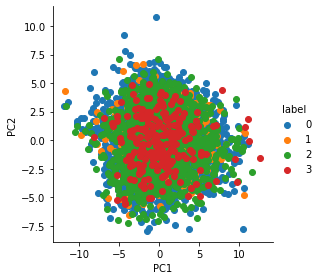

In [11]:
graph = sns.FacetGrid(data=df_4viz, hue='label', height=4)
graph.map(plt.scatter, 'PC1','PC2').add_legend()
plt.show()

The above figure shows the relationship between the two principal components with highest varience. 

Now, let me try to visualize the four principal components with the highest variance in a scatter plot:

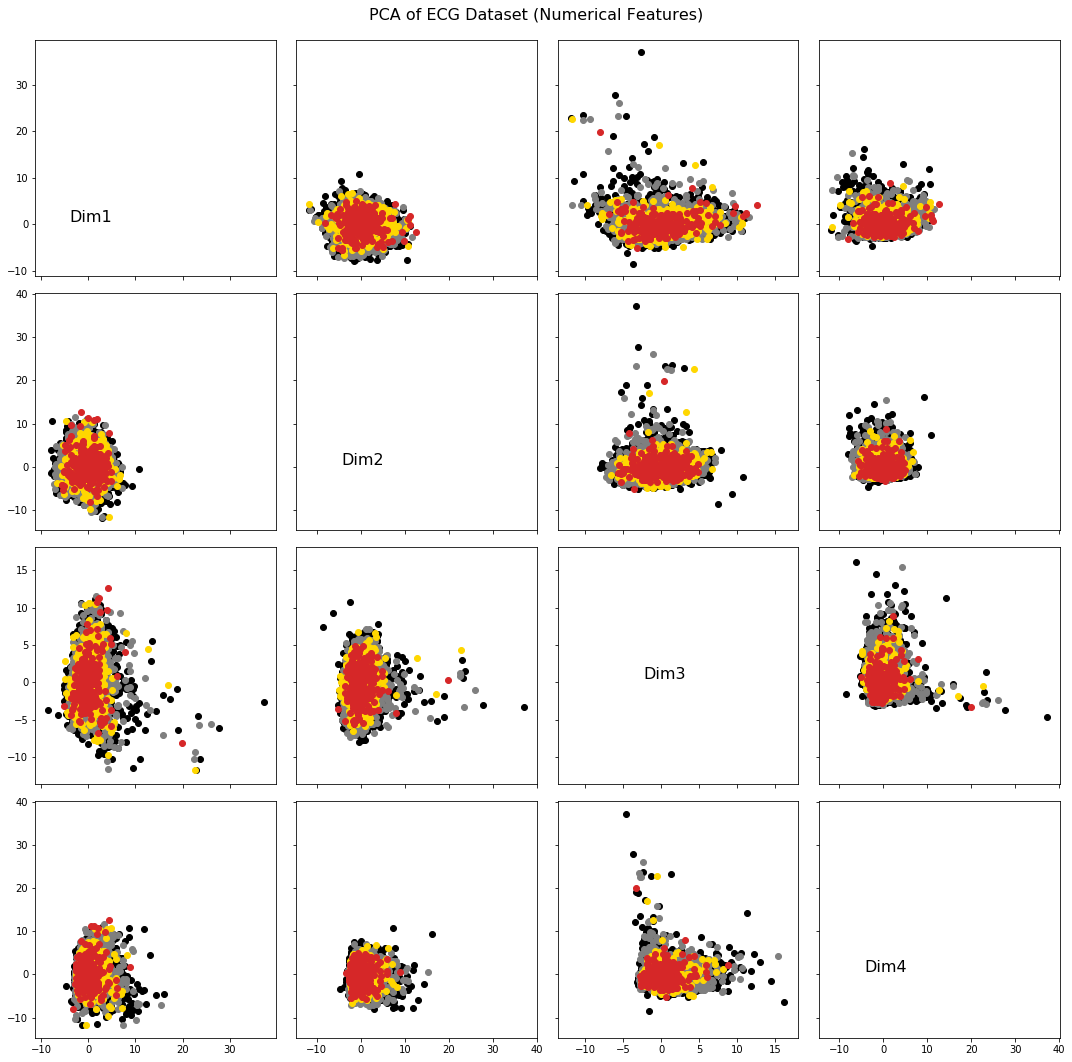

In [12]:
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('PCA of ECG Dataset (Numerical Features)', fontsize=16)
labels = list(y.unique()) #[0, 2, 1, 3]
colors = ['black','tab:gray','gold','tab:red']
for i in range(4):
    for j in range(4):
        if i==j:
            ax[i,j].text(0.5, 0.5,'Dim'+ str(i+1), ha='center', fontsize=16)
        else:
            for label, color in zip(labels, colors):
                xdata = df_4viz[df_4viz['label']==label][pc_names[i]]
                ydata = df_4viz[df_4viz['label']==label][pc_names[j]]
                ax[i, j].scatter(x=xdata, y=ydata, color=color)
                ax[i, j].set(xlabel=None, ylabel=None)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Now, I define a logistic regression classifier:

In [13]:
clf1 = LogisticRegression(solver='lbfgs', multi_class='auto')
clf1.fit(XN_train, y_train)
y_pred = clf1.predict(XN_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1010
           1       0.67      0.51      0.58       148
           2       0.53      0.26      0.35       491
           3       0.60      0.54      0.57        57

    accuracy                           0.68      1706
   macro avg       0.63      0.56      0.57      1706
weighted avg       0.65      0.68      0.64      1706



Actully, it is not bad, compared with the baseline.

## 3. Classifier-II
Construct a logistic regression classifier for the last 20 categorial features (Classifier-II).

First, I extract categorial features for this classifier (target values in y vector is as before):

In [14]:
XC = df.iloc[:,51:71].copy() 
y = df.loc[:,"label"]
XC.head()

,categ_feat0,categ_feat1,categ_feat2,categ_feat3,categ_feat4,categ_feat5,categ_feat6,categ_feat7,categ_feat8,categ_feat9,categ_feat10,categ_feat11,categ_feat12,categ_feat13,categ_feat14,categ_feat15,categ_feat16,categ_feat17,categ_feat18,categ_feat19
0,V3,Y1,I3,R2,E2,D2,I2,T1,O1,F0,T1,I2,D2,F4,I3,U1,N4,S2,J5,N2
1,V3,Y2,I4,R3,E2,D2,I4,T1,O6,F2,T1,I2,D2,F6,I2,U1,N4,S2,J6,N0
2,V3,Y1,I2,R2,E2,D2,I4,T0,O2,F0,T1,I2,D0,F4,I3,U1,N4,S2,J5,N2
3,V3,Y1,I2,R1,E2,D1,I3,T1,O3,F0,T1,I1,D0,F4,I3,U1,N4,S1,J3,N2
4,V3,Y2,I4,R2,E2,D2,I3,T1,O2,F0,T2,I2,D4,F5,I3,U1,N4,S2,J4,N2


Second, I should encode the categorial feature values to numerical correspondings. Let's see what are the categorial values in each columns:

In [15]:
for i in range(20):
    tmp = list(XC.iloc[:,i].unique())
    print(sorted(tmp))

['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']
['Y1', 'Y2', 'Y3']
['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7']
['R0', 'R1', 'R2', 'R3']
['E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7']
['D0', 'D1', 'D2', 'D3', 'D4']
['I1', 'I2', 'I3', 'I4', 'I5']
['T0', 'T1', 'T2', 'T3']
['O0', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6']
['F0', 'F1', 'F2', 'F4']
['T0', 'T1', 'T2', 'T3', 'T4', 'T5']
['I1', 'I2', 'I3']
['D0', 'D1', 'D2', 'D3', 'D4', 'D5']
['F3', 'F4', 'F5', 'F6', 'F7']
['I0', 'I1', 'I2', 'I3', 'I4', 'I5']
['U0', 'U1', 'U2']
['N2', 'N3', 'N4']
['S0', 'S1', 'S2', 'S3', 'S4']
['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7']
['N0', 'N1', 'N2', 'N3', 'N4', 'N5']


It seems they are "ordinal" categorial values (note to indices, e.g., V0, V1, V2, etc.). One way of encoding such data is integer encoding:

In [16]:
oe = OrdinalEncoder()
for i in range(20):
    oe.fit(XC)
    XC_enc = oe.fit_transform(XC)

In [17]:
XC_enc = pd.DataFrame(XC_enc, columns=XC.columns )
XC_enc.head()

,categ_feat0,categ_feat1,categ_feat2,categ_feat3,categ_feat4,categ_feat5,categ_feat6,categ_feat7,categ_feat8,categ_feat9,categ_feat10,categ_feat11,categ_feat12,categ_feat13,categ_feat14,categ_feat15,categ_feat16,categ_feat17,categ_feat18,categ_feat19
0,3.0,0.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,2.0,4.0,2.0
1,3.0,1.0,4.0,3.0,2.0,2.0,3.0,1.0,6.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,5.0,0.0
2,3.0,0.0,2.0,2.0,2.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,2.0,2.0,4.0,2.0
3,3.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0
4,3.0,1.0,4.0,2.0,2.0,2.0,2.0,1.0,2.0,0.0,2.0,1.0,4.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0


Third, I do train and test split with 80:20 ratio (+ stratifying as our
data is imbalanced):

In [18]:
XC_train, XC_test, y_train, y_test = train_test_split(XC_enc, y, test_size=0.2, random_state=42, stratify = y)

Normalization:

In [19]:
scaler = StandardScaler()
XC_train = pd.DataFrame(scaler.fit_transform(XC_train), columns=XC_train.columns)
XC_test = pd.DataFrame(scaler.transform(XC_test), columns=XC_test.columns)

And PCA:

In [20]:
pca = PCA(.95)
pca.fit(XC_train)
print('Number of components after fitting the pca model=', pca.n_components_) #pca.components_.shape #(17,20)
XC_pca_train = pca.transform(XC_train)
XC_pca_test = pca.transform(XC_test)

Number of components after fitting the pca model= 17


17 vs 20? Not much linear dependency in features. Let's try Kernel PCA this time:

In [21]:
kpca = KernelPCA(kernel='rbf')
kpca.fit(XC_train)
XC_kpca_train = kpca.transform(XC_train)
XC_kpca_test = kpca.transform(XC_test)

In [22]:
print('Number of eigenvalues =', len(kpca.lambdas_))  # XC_kpca_train.shape #(6822, 6810)

Number of eigenvalues = 6810


Therefore, Kernel PCA assigns 6822 training samples to 6810 vectors. Obviously this dimensionality reduction is not helpful. I had better select the number of components in Kernel PCA. For this purpose, I plot the cumulative sum of eigenvalues ratio:

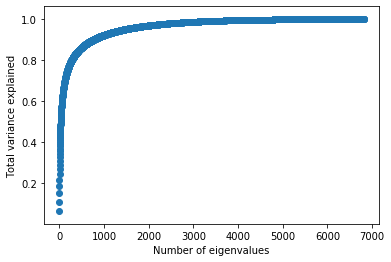

In [23]:
x_data = range(1,len(kpca.lambdas_)+1)
# we know that the eigenvalues are sorted in decreasing order in lambdas_
y_data = np.cumsum(kpca.lambdas_)/np.sum(kpca.lambdas_)

plt.scatter(x_data, y_data)
plt.xlabel("Number of eigenvalues")
plt.ylabel("Total variance explained")
plt.show()

It seems that the best value for the number of components is between 1500-2000. After 2000, the curve is monotone, so little variance is gained by retaining more values. Therefore, I redo Kernel PCA with a value such as 2000 for the number of components:

In [24]:
kpca = KernelPCA(n_components=2000, kernel='rbf')
kpca.fit(XC_train)
XC_kpca_train = kpca.transform(XC_train)
XC_kpca_test = kpca.transform(XC_test)

Now, I define a logistic regression classifier over the result of Kernel PCA:

In [25]:
clf2a = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=4000)
clf2a.fit(XC_kpca_train, y_train)
y_pred = clf2a.predict(XC_kpca_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      1010
           1       0.29      0.01      0.03       148
           2       0.67      0.59      0.63       491
           3       1.00      0.02      0.03        57

    accuracy                           0.70      1706
   macro avg       0.67      0.38      0.37      1706
weighted avg       0.68      0.70      0.66      1706



Let's find what if we construct a model before applying dimensionality reduction:

In [26]:
clf2b = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=4000)
clf2b.fit(XC_train, y_train)
y_pred = clf2b.predict(XC_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1010
           1       0.30      0.04      0.07       148
           2       0.68      0.61      0.64       491
           3       0.62      0.09      0.15        57

    accuracy                           0.71      1706
   macro avg       0.58      0.41      0.42      1706
weighted avg       0.67      0.71      0.67      1706



As expected, the classification has sligthly better performance without dimensionality reduction. However, both classifiers have poor performance over this imbalanced dataset.

## 4. Voting classifier

Last, I construct a voting classifier over the claffiers clf1 and clf2b:

In [27]:
def final_decision(clf1_out, clf1_prob, clf2_out, clf2_prob):
    """
    Params:
    clf1_out : Classification results of Classifier1 (numerical features)
    clf1_prob: Probabilities of the clf1_output
    clf2_out : Classification result of Classifier2 (categorial features)
    clf2_prob: Probabilities of the clf2_output
    
    Attributes:
    final_out: Final classification result
    final_prob: Probabilities of the final classification result
    
    All params and attributes are vectors.
    """
    n = len(clf1_out)
    final_out = np.zeros(n)
    final_prob = np.zeros(n)
    for i in range(n):        
        if clf1_out[i] == clf2_out[i]:
            final_out[i] = clf1_out[i]
            final_prob[i] = clf1_prob[i] + clf2_prob[i] - (clf1_prob[i] * clf2_prob[i])
        else:
            if clf1_prob[i] > clf2_prob[i]:
                final_out[i] = clf1_out[i]
                final_prob[i] = clf1_prob[i]
            else:
                final_out[i] = clf2_out[i]
                final_prob[i] = clf2_prob[i]            
    return final_out, final_prob

In [28]:
y1_pred = clf1.predict(XN_test)
y1_prob = np.amax(clf1.predict_proba(XN_test),1)
y2_pred = clf2b.predict(XC_test)
y2_prob = np.amax(clf2b.predict_proba(XC_test),1)

final_pred, final_prob = final_decision(y1_pred, y1_prob, y2_pred, y2_prob)

In [29]:
print(classification_report(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1010
           1       0.83      0.30      0.44       148
           2       0.77      0.48      0.59       491
           3       0.71      0.35      0.47        57

    accuracy                           0.75      1706
   macro avg       0.76      0.52      0.58      1706
weighted avg       0.75      0.75      0.72      1706



Let's compare the combining result (the ensemble above) with each classifiers clf1 and clf2b results, separately: 

In [30]:
print(classification_report(y_test, y1_pred))
print(classification_report(y_test, y2_pred))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      1010
           1       0.67      0.51      0.58       148
           2       0.53      0.26      0.35       491
           3       0.60      0.54      0.57        57

    accuracy                           0.68      1706
   macro avg       0.63      0.56      0.57      1706
weighted avg       0.65      0.68      0.64      1706

              precision    recall  f1-score   support

           0       0.72      0.89      0.80      1010
           1       0.30      0.04      0.07       148
           2       0.68      0.61      0.64       491
           3       0.62      0.09      0.15        57

    accuracy                           0.71      1706
   macro avg       0.58      0.41      0.42      1706
weighted avg       0.67      0.71      0.67      1706



The ensemble's result is clearly more "balanced". For comparison, consider the weighted avg of f1-scores: We see that the ensemble shows better performance (0.72 vs 0.64 or 0.67). 

## Appendix. How to improve?

    1- Try different classification method. For instance, the weighted SVM is more appropriate for imbalanced dataset. However, the SVM is not as easy as logistic regression for multi-class classification.
    2- Construct one unique model for all features (i.e., mix of numerical and categorial features), for instance, tree-based methods such as Random Forests and AdaBoost.
    3- Try different encoding method for categorial data, such as One Hot encoding.